<a href="https://colab.research.google.com/github/jhryulab/neural_style_transfer/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd

import PIL
import PIL.Image

tf.__version__

'2.6.0'

In [2]:
! git clone https://github.com/jhryulab/neural_style_transfer.git

Cloning into 'neural_style_transfer'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 2), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [3]:
os.chdir('/content/neural_style_transfer')

# Load content and style images

In [4]:
def load_img(path_to_img):

  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img.shape

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  img = img[tf.newaxis,:]

  # short_dim = min(shape)  
  # if short_dim != long_dim:

  #   img = tf.image.crop_and_resize(img, 
  #                                  tf.cast([[0, 0, short_dim, short_dim]], tf.float32),
  #                                  tf.cast([0],tf.int32),
  #                                  (short_dim, short_dim))
  #   shape = tf.cast(tf.shape(img)[:-1], tf.float32)

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  
  return img

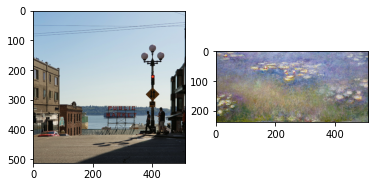

In [5]:
CONTENT_PATH = 'image/seattle.jpg'
STYLE_PATH = 'image/nymphea.jpg'

# content_image
content_image = load_img(CONTENT_PATH)
style_image = load_img(STYLE_PATH)

plt.subplot(1,2,1)
plt.imshow(tf.squeeze(content_image))
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(style_image))

In [6]:
content_image.shape, style_image.shape

(TensorShape([1, 512, 512, 3]), TensorShape([1, 238, 511, 3]))

# Build content and style extractor

In [7]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The paper used content representation on layer 'conv4 2' and the style representation on layers conv1 1, conv2 1, conv3 1, conv4 1 and conv5 1.

(wl = 1/5 in those layers, wl = 0 in all other layers) . The
ratio α/β was either 1 × 10−3
(Fig 3 B), 8 × 10−4
(Fig 3
C), 5 × 10−3
(Fig 3 D), or 5 × 10−4
(Fig 3 E, F).


In [8]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [9]:
def make_extractor(layer_names):
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False)
  vgg.trainable = False

  inputs = vgg.input
  outputs = [vgg.get_layer(name).output for name in layer_names]

  extractor = tf.keras.Model(inputs, outputs)

  return extractor

In [23]:
# check if it works

content_extractor = make_extractor(content_layers)
content_representation = content_extractor(content_image)
style_extractor = make_extractor(style_layers)
style_representation = style_extractor(style_image)

In [24]:
content_representation.shape, len(style_representation)

(TensorShape([1, 64, 64, 512]), 5)

In [25]:
[x.shape for x in style_representation]

[TensorShape([1, 238, 511, 64]),
 TensorShape([1, 119, 255, 128]),
 TensorShape([1, 59, 127, 256]),
 TensorShape([1, 29, 63, 512]),
 TensorShape([1, 14, 31, 512])]

# For style layers, calculate gram matrix which contains information about style

$ G^l_{ij} = \Sigma_k F^l_{ik} F^l_{jk} $

where $ F^l_{jk}$ shape is (# of feature map) * (# of pixels)

remember that outputs are always [batch, height, width, channel(feature maps)] = [b, i, j, (c or d)].


Then rewrite

$ G^l_{bij} = \Sigma_{ij} F^l_{bijc} F^l_{bijd} $



In [10]:
def gram_matrix(input_tensor):
  result = tf.einsum('bijc,bijd->bij', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  # paper divides by (2NM)^2 after squaring but we do here
  return result


# Build extractor

In [11]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = make_extractor(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # rgb -> gbr, zero-centered by imagenet means
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [26]:
extractor = StyleContentModel(style_layers, content_layers)

In [44]:
style_targets = extractor(style_image)['style'] # style representation
content_targets = extractor(content_image)['content'] # content representation

# Train

try one step train first

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


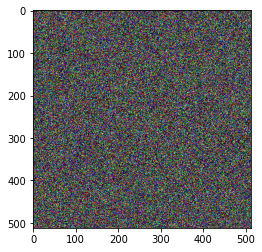

In [48]:
image = tf.random.normal(content_image.shape)
plt.imshow(tf.squeeze(image))

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [33]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Define loss function

$ L_{total} = a * L_{content} + b * L_{style} $

$ L_{style} $ is weighted average of individual layer loss

In [34]:
style_weight=1e-3
content_weight=1

In [36]:
num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *=  1/num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= 1/num_content_layers
    
    loss = style_weight * nstyle_loss + content_weight * content_loss
    return loss

TensorShape([1, 512, 512, 3])

In [46]:
style_outputs = extractor(noise)['style']